BIG DATA IN BUSINESS AND INDUSTRY, PRACTICAL WORK\
Taru Haimi, 0565878\
Joona Ylijoki, 0522866

TASK: Create ML model to forecast user's next exercise type, time and, possibly, duration

In [43]:
#########################################
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pa_functions as pafuns

Loading data from json files into one dataframe.\
Source code: READ_workoutsToMoodle.py 

In [44]:
with open("folderpath.txt",'r') as rfile:
    folderpath = rfile.read()

data = pd.DataFrame()
for file in os.listdir(folderpath):
    newdf = pafuns.read_file_to_df(os.path.join(folderpath, file))
    data = pd.concat([data, newdf], ignore_index=True)
data.reset_index(drop=True, inplace = True)

EXPLORATORY DATA ANALYSIS

1) Finding out all different types of sports and how many times they occur in data

In [45]:
sporttypes = data["sport"].unique()
print(sporttypes)
print("Number of different sport types: ", len(data["sport"].unique()))

# Count occurences;
counts = data.groupby('sport').size().reset_index(name='count')

print('How many times sports occur in data:')
print(counts)


['WALKING' 'WEIGHT_TRAINING' 'RUNNING' 'SKIING_CROSS_COUNTRY' 'SWIMMING'
 'BADMINTON' 'ROLLER_SKATING' 'FITNESS_WALKING' 'CYCLING_SPORT' 'CROSSFIT'
 'RUNNING_CANICROSS' 'ICE_SKATING' 'BEACH_VOLLEY' 'CYCLING_TRANSPORTATION'
 'STAIR_CLIMBING' 'CROSS_TRAINING' 'STRETCHING']
Number of different sport types:  17
How many times sports occur in data:
                     sport  count
0                BADMINTON     38
1             BEACH_VOLLEY      1
2                 CROSSFIT      9
3           CROSS_TRAINING      6
4            CYCLING_SPORT     51
5   CYCLING_TRANSPORTATION     54
6          FITNESS_WALKING      1
7              ICE_SKATING     27
8           ROLLER_SKATING      6
9                  RUNNING     35
10       RUNNING_CANICROSS     89
11    SKIING_CROSS_COUNTRY     94
12          STAIR_CLIMBING     17
13              STRETCHING      1
14                SWIMMING    115
15                 WALKING   2728
16         WEIGHT_TRAINING    184


It's notable that beach volley, fitness walking and stretching occur in data only once, and additionally crosstraining and roller skating 6 times and crossfit 9 times. If the person who has recorded these have done these sports only couple times during four years, these sports can probably be excluded from the model, because their occurence is so rare and hard to predict. 

2. Exploring data variables and their types

The dataset includes 19 different variables and 3456 observations between time period 3.5.2017-18.8.2020. The variables are

In [46]:
print(data.columns)

Index(['sport', 'source', 'created_date', 'start_time', 'end_time',
       'duration_s', 'distance_km', 'calories_kcal', 'altitude_min_m',
       'altitude_max_m', 'speed_avg_kmh', 'speed_max_kmh', 'ascend_m',
       'descend_m', 'start_lat', 'start_long', 'end_lat', 'end_long',
       'hydration_l'],
      dtype='object')


All variables are mostly numerical data, only variables sport and source are string data, and create_date, start_time and end_time are datetime data. Additionally sport and source -variables seem to be categorical data.

3. Exploring starting hours vs sports and their average duration.

These barplots describe relations between starting times and sport types, and in addition they show how the durations of activities vary between clock times and sports. It can be observed that only walking activities are started to record round the clock, 2am-10pm.  Then most notable is that beach volley, fitness walking and stretching have records only in single specific hours. Roller skating has also very specific starting times, between 8am-12am. Then many sports have pretty similar timeline starting from early morning and ending in late evenin. The exact starting and ending times vary between 4-9am and 17-20pm. 

** jotain keskiarvokeston vaihtelusta kellonaikojen ja urheilulajien välillä? **

Based on these notes, the starting time might be a good variable to estimate next exercise type, but certainly not alone. Some sports can occur only certain hours of the day which gives good limitations for model, but most of sports can occur same time of the day, so more features are definitely needed to estimate these hours. 


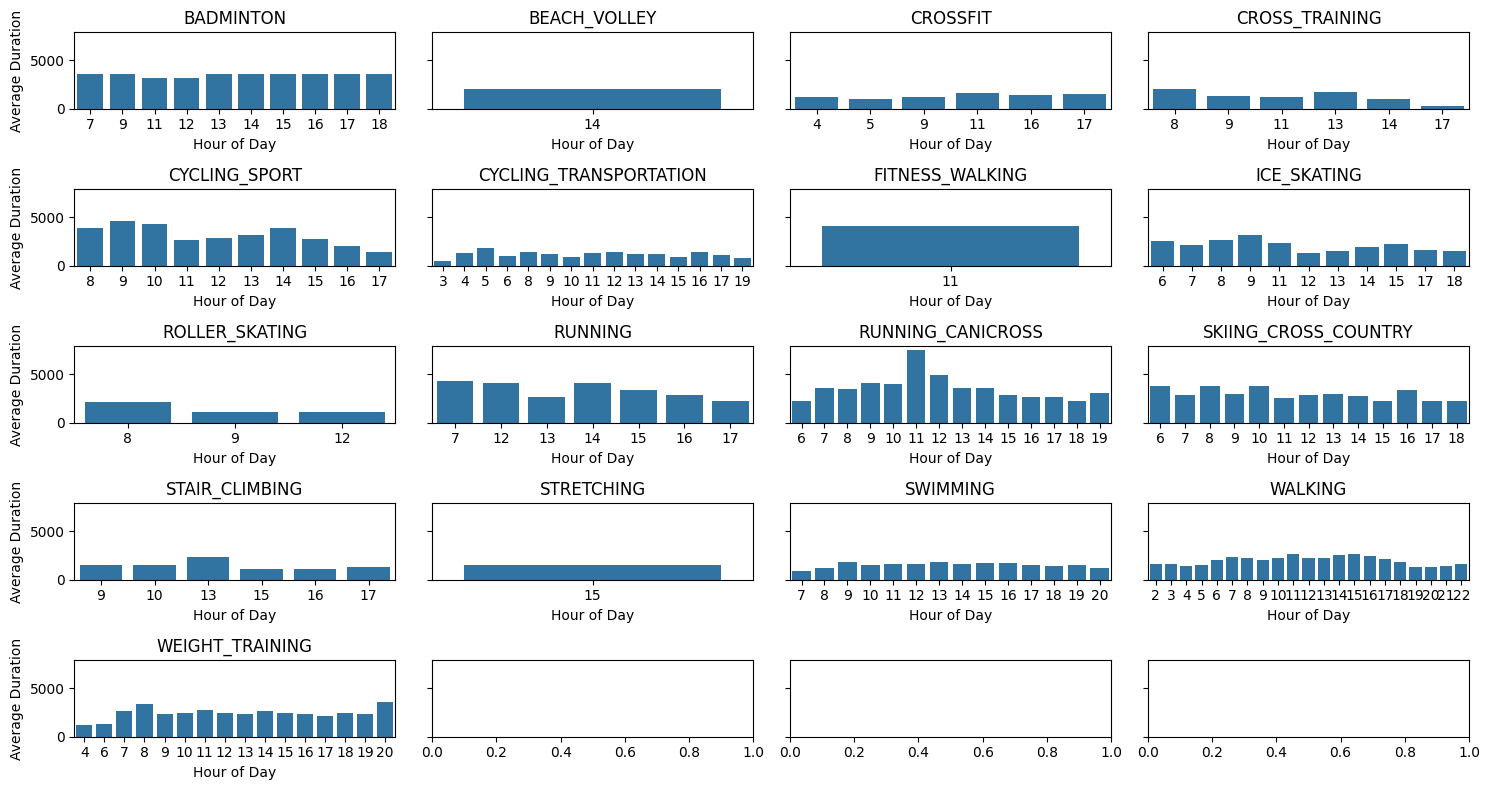

In [47]:
# Convert 'timestamp' column to datetime
data['start_time'] = pd.to_datetime(data['start_time'])

# Extract the hour from the timestamp
data['start_hour'] = data['start_time'].dt.hour

# Calculate the average duration for each hour and sport type
# hourlydata = data.copy()
mean_durations = data.groupby(['sport', 'start_hour'])['duration_s'].mean().reset_index()

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 8), sharey=True)

# Flatten the 2D array of subplots
axes = axes.flatten()

# Iterate over sport types
for i, (sport, hourlydata) in enumerate(mean_durations.groupby('sport')):
    sns.barplot(x='start_hour', y='duration_s', data=hourlydata, ax=axes[i])
    axes[i].set_title(sport)
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel('Average Duration')

# Adjust layout
plt.tight_layout()
plt.show()

4. Exploring weekdays vs sports and their average duration.

These barplots tell on which weekdays certain sports have been recorded, and again also shows how the average durations are distributed between weekdays and sports. Most sports have records from every day or almost every day, but notable are those sports that have records only certain days. This kind of sports are stretching and beach volley. Additionally cross_training and roller_skating have limited weekdays to be recorded. Most of durations between weekdays in same sport type don’t vary a lot, but durations between sport types in same weekday are very different from each other.

The weekday might be a good variable to be used in model, since with it some possible sports can be cut off from options. For example, if other variables would estimate that the next sport is beach volley but it’s Wednesday, that sport probably is not the correct one. Also if the estimations showed that the duration of sport would be short, the sports with long average duration can be cut off. 


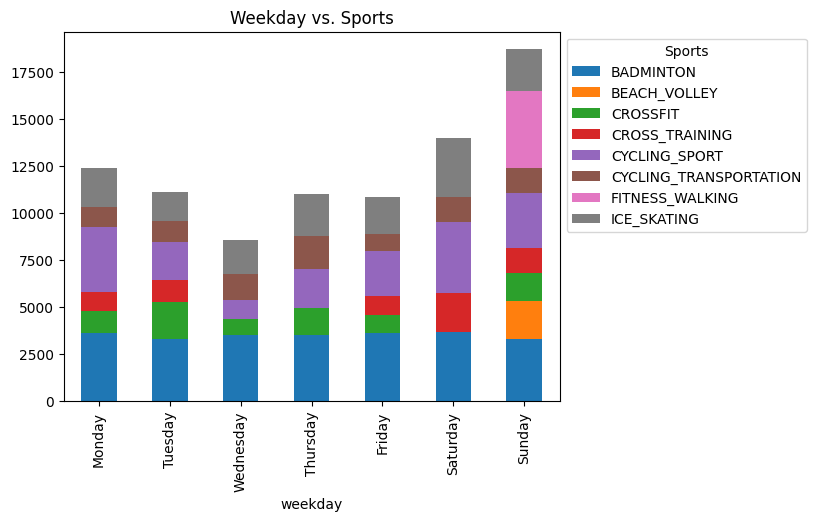

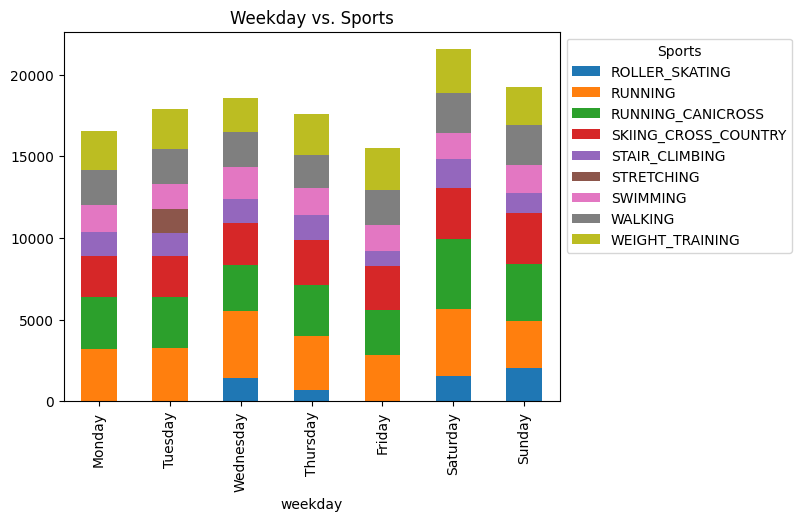

In [48]:
# Extract the weekday from the timestamp
data['weekday'] = data['start_time'].dt.weekday

# Calculate the average duration for each weekday and sport type
mean_durations = data.groupby(['sport', 'weekday'])['duration_s'].mean().reset_index()

# Pivot the data to have weekdays as columns
mean_durations_pivot = mean_durations.pivot(index='weekday', columns='sport', values='duration_s').reset_index()

# Plot the average duration per sport and  per weekday in two parts:
datapart1 =  mean_durations_pivot.iloc[:,list(range(0, 9))]
datapart2 = mean_durations_pivot.iloc[:, [0] + list(range(9, 18))]
pafuns.plot_weekday_data(datapart1)
pafuns.plot_weekday_data(datapart2)

5. Exploring seasons vs sports and their average duration.

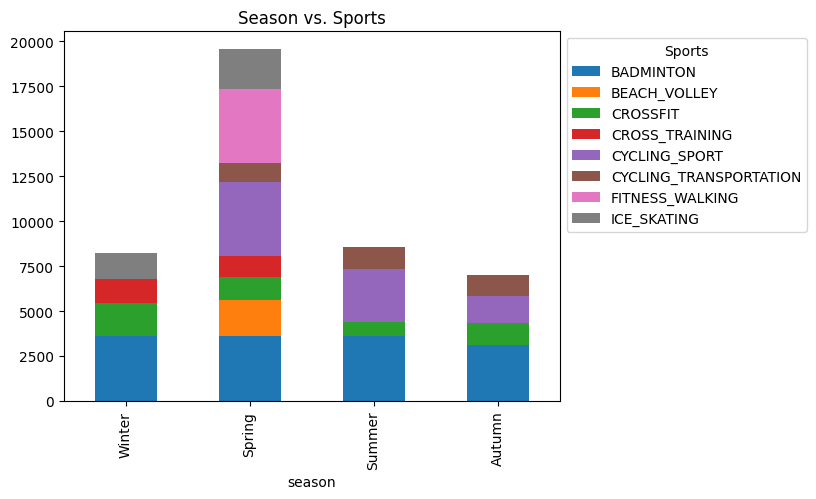

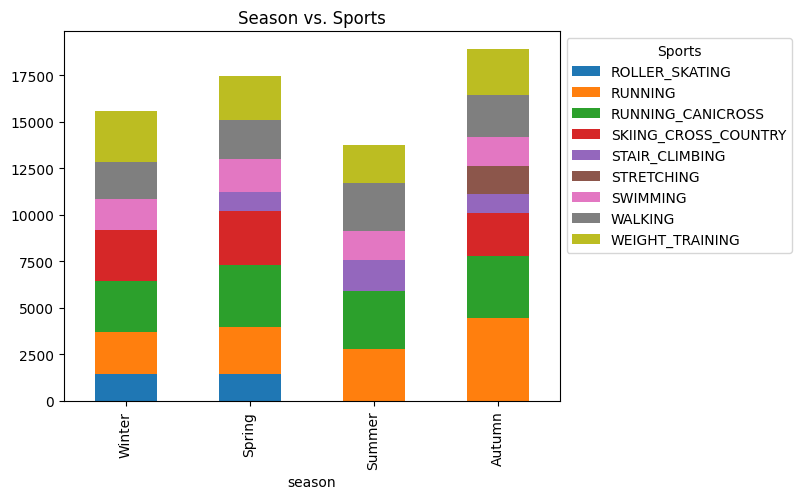

In [49]:
data['month'] = data['start_time'].dt.month
# Define a mapping from month to season
month_to_season = {
    12: '1',
    1: '1',
    2: '1',
    3: '2',
    4: '2',
    5: '2',
    6: '3',
    7: '3',
    8: '3',
    9: '4',
    10: '4',
    11: '4'
}
# Create a new column for seasons
data['season'] = data['month'].map(month_to_season)

# Calculate the average duration for each weekday and sport type
mean_durations = data.groupby(['sport', 'season'])['duration_s'].mean().reset_index()

# Pivot the data to have weekdays as columns
mean_durations_pivot = mean_durations.pivot(index='season', columns='sport', values='duration_s').reset_index()

# Plot the average duration per sport and  per weekday in two parts:
datapart1 =  mean_durations_pivot.iloc[:,list(range(0, 9))]
datapart2 = mean_durations_pivot.iloc[:, [0] + list(range(9, 18))]
pafuns.plot_season_data(datapart1)
pafuns.plot_season_data(datapart2)

6. Exploring locations of sports

There're some observations of sports that are recorded outside of Finland. Their total count is however very small when compared to the whole data amount, and they all are sport type "walking". These are probably from holiday or working trips, and the person was "walking around in a new city". These sport activities are probably very anomalous from normal life cycle, so they can be excluded from the model because they are possible outliers and could give model wrong idea.

In [50]:
# Bounding box for Finland's coordinate
finland_bounding_box = {
    'min_latitude': 60,
    'max_latitude': 70,
    'min_longitude': 20,
    'max_longitude': 30,
}

# Check if each location is outside Finland
outside_finland = (
    (data['start_lat'] < finland_bounding_box['min_latitude']) |
    (data['start_lat'] > finland_bounding_box['max_latitude']) |
    (data['start_long'] < finland_bounding_box['min_longitude']) |
    (data['start_long'] > finland_bounding_box['max_longitude'])
)

# Locations outside Finland and their count
df_outside_finland = data[outside_finland]
print(f'Number of locations outside Finland: ' + str(len(df_outside_finland)))


Number of locations outside Finland: 30


DATA PREPROCESSING

- Missing values handling?
- Encoding categorical variables
- Scaling 

1. Removing variables and observations

First the observations outside Finland are excluded. The variables that were thought to be important in this modeling case were explored in above section, so the other variables are consider more insignificant and they are removed from the dataset that is used for modeling. 

Then from current data, observations that contain nan values are removed. Then if observation's durations is very short (5min), they're also excluded from the model because they might be recorded by mistake.

In [58]:
modeldata = data[~outside_finland]
modeldata = modeldata[['sport','start_hour', 'weekday', 'season', 'duration_s','calories_kcal']]
modeldata = modeldata.dropna().reset_index(drop=True)
modeldata = modeldata[modeldata['duration_s'] >= 300].reset_index(drop=True)